## 1. 符号规定

坐标变换数学符号规范 (System Prompt)

在后续的数学推导中，请严格遵守以下符号定义与变换规则：

### 通用书写格式

所有变量（包括旋转矩阵 $\mathbf{R}$）必须严格标注左上角和右下角：

格式：$^{\text{Target}}\mathbf{Symbol}_{\text{Start}\_\text{End}}$

左上角 (Target)：表示该变量是在哪个坐标系下表达的（即投影系/目标系）。

右下角 (Start_End)：表示变换的流向或相对关系。

### 符号定义与物理/数学二元性

A. 旋转矩阵 $^{\text{A}}\mathbf{R}_{\text{A}\_\text{B}}$

下标定义 ($A\_B$)：表示物理动作是从 A 系出发，旋转对齐到 B 系。

数学作用 (Mapping)：作为一个算子，它的实际功能是将 B 系的坐标映射回 A 系。

记忆口诀：动作是 $A \to B$，算子是 $B \to A$。

B. 平移/位置矢量 $^{\text{A}}\mathbf{t}_{\text{A}\_\text{B}}$

下标定义 ($A\_B$)：表示从 A 系原点指向 B 系原点。

物理含义：B 系的原点在 A 系中的坐标描述。

动作理解：相当于把 A 的原点平移到了 B 的原点。

C. 坐标点 $^{\text{A}}\mathbf{p}$

含义：点 P 在 A 系中的坐标数值。

### 核心运算规则：链式法则 (Chain Rule)

在构建变换方程时，必须满足下标相邻消去原则。右侧算子的右下角后项（输入系）必须与被运算向量的左上角（所在系）一致，从而“抵消”得到左侧的目标系。

标准公式：

$$^{\text{A}}\mathbf{p} = {}^{\text{A}}\mathbf{R}_{\text{A}\_\text{B}} \cdot {}^{\text{B}}\mathbf{p} + {}^{\text{A}}\mathbf{t}_{\text{A}\_\text{B}}$$

链式检验：

旋转项：$({}^{\text{A}}\mathbf{R}_{\mathbf{A\_\underline{B}}}) \cdot ({}^{\mathbf{\underline{B}}}\mathbf{p}) \rightarrow {}^{\text{A}}\mathbf{p}$

(这里的 B 与 B 相邻，逻辑上抵消，保留 A)

## 2. Tr的验证

经过验证，calib.txt中的Tr表示 $^CT_{C\_L}$ (C->L参考系旋转，LiDAR -> Camera的坐标转换)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 0. 数据准备 (模拟或读取)
# ==========================================
# --- 配置路径 ---
base_path = '../data/07/'  # 假设 notebook 在 notebooks 文件夹下


def read_calib(file_path):
    """
    读取KITTI calib文件，返回字典。
    重点关注 Tr: Velodyne -> Camera 变换矩阵
    """
    calib_data = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.split(':', 1)
                calib_data[key] = np.array([float(x) for x in value.split()])
    return calib_data

calib = read_calib(base_path + 'calib.txt')

# 1. 重新构建完整的 4x4 变换矩阵 Tr (即 T_C_L)
calib = read_calib(base_path + 'calib.txt')
Tr = np.eye(4)
Tr[:3, :4] = calib['Tr'].reshape(3, 4)

# ==========================================
# 验证代码：使用 ^C R_{C_L} 验证基向量变换
# ==========================================

# 1. 准备旋转矩阵
# Tr_matrix 来自 calib.txt, 形状 (3, 4)
# 我们提取前 3x3 部分，即旋转矩阵 ^C R_{C_L}
# 含义: 这是一个算子，将 L 系的向量映射到 C 系
R_CL = Tr[:3, :3] 

print(f"--- 旋转矩阵 ^C R_{{C\_L}} ---\n{np.round(R_CL, 4)}\n")

# 2. 定义测试点 (LiDAR 系下的基向量)
# Case A: LiDAR 的 X 轴方向 (前方)
# 向量表示: ^L p = [1, 0, 0]^T
p_L_forward = np.array([1, 0, 0]).reshape(3, 1) 

# Case B: LiDAR 的 Z 轴方向 (上方)
# 向量表示: ^L p = [0, 0, 1]^T
p_L_up = np.array([0, 0, 1]).reshape(3, 1) 


# 3. 执行变换
# 公式: ^C p = ^C R_{C_L} * ^L p
# 注意: 这里是标准的矩阵 x 列向量乘法 (NumPy中 1D array dot 等价于列向量运算)
p_C_from_forward = R_CL @ p_L_forward
p_C_from_up      = R_CL @ p_L_up

# 4. 打印验证结果
print("【验证 A】LiDAR 前方 (1, 0, 0) -> Camera 系坐标:")
print(f"  计算结果: {np.round(p_C_from_forward, 4)}")
print(f"  预期结果: [0. 0. 1.] (Camera 的 Z 轴/前方)")
# 判定
match_A = np.allclose(p_C_from_forward, np.array([0, 0, 1]).reshape(3, 1), atol=1e-2)
print(f"  >>> 验证结果: {'SUCCESS ✅' if match_A else 'FAIL ❌'}")

print("\n" + "-"*40 + "\n")

print("【验证 B】LiDAR 上方 (0, 0, 1) -> Camera 系坐标:")
print(f"  计算结果: {np.round(p_C_from_up, 4)}")
print(f"  预期结果: [0. -1. 0.] (Camera 的 -Y 轴/上方)") 
# 注意: Camera Y是下，所以上方是 -Y
# 判定
match_B = np.allclose(p_C_from_up, np.array([0, -1, 0]).reshape(3, 1), atol=1e-2)
print(f"  >>> 验证结果: {'SUCCESS ✅' if match_B else 'FAIL ❌'}")

--- 旋转矩阵 ^C R_{C\_L} ---
[[-0.0019 -1.     -0.008 ]
 [-0.0065  0.0081 -0.9999]
 [ 1.     -0.0018 -0.0065]]

【验证 A】LiDAR 前方 (1, 0, 0) -> Camera 系坐标:
  计算结果: [[-0.0019]
 [-0.0065]
 [ 1.    ]]
  预期结果: [0. 0. 1.] (Camera 的 Z 轴/前方)
  >>> 验证结果: SUCCESS ✅

----------------------------------------

【验证 B】LiDAR 上方 (0, 0, 1) -> Camera 系坐标:
  计算结果: [[-0.008 ]
 [-0.9999]
 [-0.0065]]
  预期结果: [0. -1. 0.] (Camera 的 -Y 轴/上方)
  >>> 验证结果: SUCCESS ✅


## 3. 可视化左目相机轨迹

### 1). 定义坐标系与符号

首先根据**左上角写系**、**右下角写关系**的规范，定义本问题中的关键变量：

* **$C$ (Camera Frame)**: 摄像机坐标系（也是题目中定义的 $t=0$ 时的世界系）。
    * 轴向定义：$x$=右, $y$=下, $z$=前。
* **$L$ (LiDAR/Velodyne Frame)**: 雷达坐标系（我们希望转换到的目标系）。
    * 轴向定义：$x$=前, $y$=左, $z$=上。
* **输入变量**:
    * ${}^{\text{C}}\mathbf{p}$: 轨迹点在 $C$ 系（即原始 Camera 系）下的坐标。对应代码中的 `traj_cam`。
    * ${}^{\text{C}}\mathbf{R}_{\text{C}\_\text{L}}$: 描述 $L$ 系相对于 $C$ 系的旋转姿态。这是一个算子，功能是将 $L$ 系的向量映射到 $C$ 系。对应代码中的 `R_data` (即 `R_velo_to_cam`)。

---

### 2). 数学原理推导 (Chain Rule)

我们的目标是求出轨迹点在 $L$ 系下的坐标 ${}^{\text{L}}\mathbf{p}$。

#### 步骤 A: 建立变换方程
根据**链式法则 (Chain Rule)**，已知从 $L$ 到 $C$ 的变换关系为：

$$
{}^{\text{C}}\mathbf{p} = {}^{\text{C}}\mathbf{R}_{\text{C}\_\text{L}} \cdot {}^{\text{L}}\mathbf{p}
$$

* **检验**: 右侧算子下标 $\text{C}\_\underline{\text{L}}$ 与向量左上角 $\underline{\text{L}}$ 相邻抵消，保留目标系 $\text{C}$。等式成立。

#### 步骤 B: 求解目标变量
我们需要反解出 ${}^{\text{L}}\mathbf{p}$。在等式两边同时左乘逆矩阵 $({}^{\text{C}}\mathbf{R}_{\text{C}\_\text{L}})^{-1}$：

$$
{}^{\text{L}}\mathbf{p} = ({}^{\text{C}}\mathbf{R}_{\text{C}\_\text{L}})^{-1} \cdot {}^{\text{C}}\mathbf{p}
$$

由于旋转矩阵是**正交矩阵** (Orthogonal Matrix)，其逆矩阵等于转置矩阵：


$$
{}^{\text{L}}\mathbf{p} = ({}^{\text{C}}\mathbf{R}_{\text{C}\_\text{L}})^{T} \cdot {}^{\text{C}}\mathbf{p}
$$

---

### 3). 维度说明

如果要保持上面公示的正确，所有向量必须明确写成列向量(3, 1)或(4, 1)，即使有N个样本点，也要写成(3, N)或(4, N)。

此外，plt在显示时一般要求(N, 3)，因此在可视化前需要转置一下。

Tr_inv.T.shape: (4, 4)
traj_cam_homo.shape: (4, 1101)
traj_case1.shape  (3, 1101)
traj_case2.shape  (3, 1101)


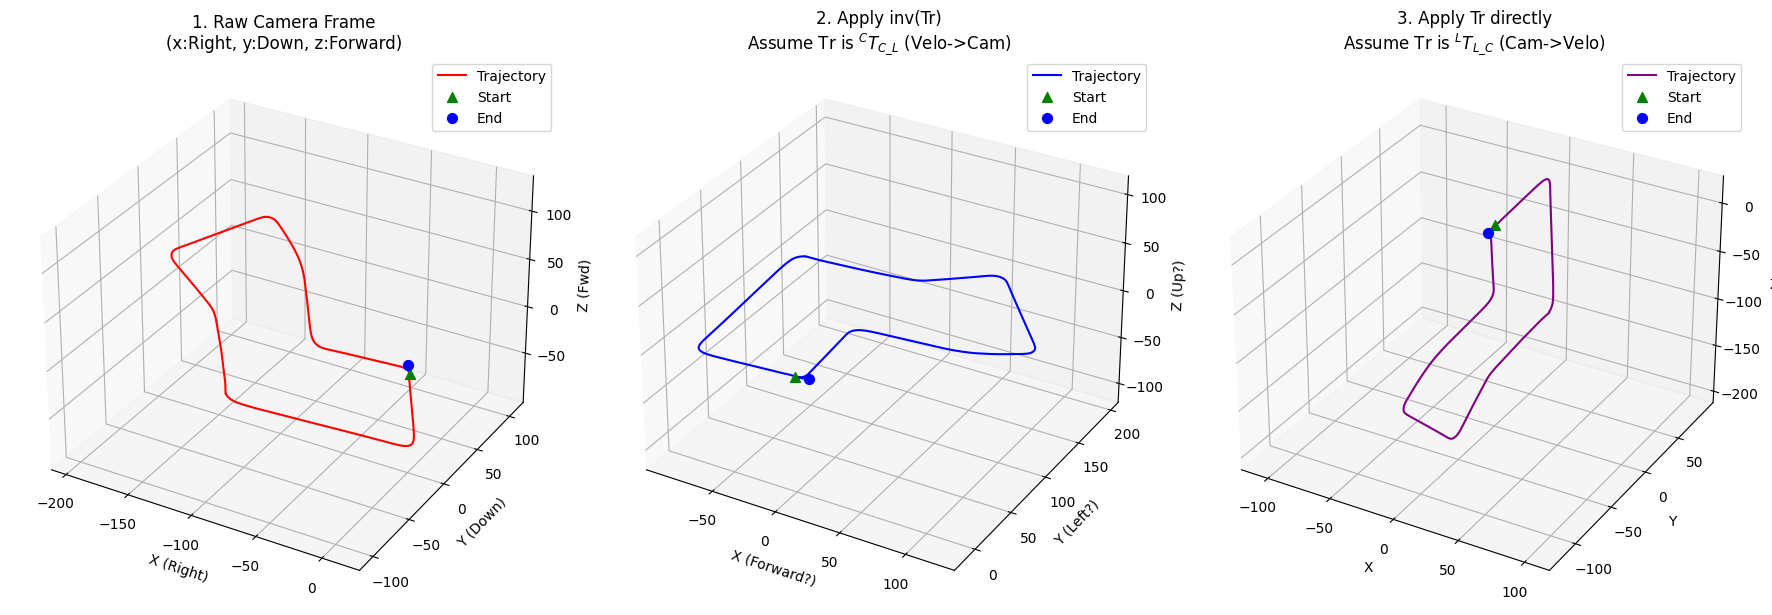

In [2]:

# 2. 准备数据: 将 (N, 3) 扩充为 (N, 4) 齐次坐标以便矩阵运算
# poses 和 traj_cam 沿用你之前的读取代码
poses = np.loadtxt(base_path + 'poses/orig_poses.txt')
traj_cam = poses[:, [3, 7, 11]] # (N, 3)
ones = np.ones((traj_cam.shape[0], 1))
traj_cam_homo = np.hstack((traj_cam, ones)) # (N, 4)
traj_cam_homo = traj_cam_homo.T # (4, N)

# ==========================================
# 1. 执行变换 (核心对比)
# ==========================================

# 【假设 1 (正确)】: Tr 是 T_C_L (LiDAR -> Camera)
# 我们有 Camera 坐标，想转回 LiDAR，需要求逆: P_L = inv(Tr) * P_C
# 注意：矩阵乘法需转置适应行向量数据: (Tr_inv @ P_C.T).T -> P_C @ Tr_inv.T
Tr_inv = np.linalg.inv(Tr)


# 第一个形状：Tr_inv.T 的转置操作后的形状
# Tr_inv.T.shape: (4, 4)
print(f"Tr_inv.T.shape: {Tr_inv.T.shape}")

# 第二个形状：traj_cam_homo 的形状
# traj_cam_homo.shape: (1101, 4)
print(f"traj_cam_homo.shape: {traj_cam_homo.shape}")

traj_case1 = Tr_inv @ traj_cam_homo 
traj_case1 = traj_case1[:3, :] # 去掉齐次项

# 【假设 2 (错误)】: 假设 Tr 是 T_L_C (Camera -> LiDAR)
# 由于先取逆再转置抵消，只需要直接把 Tr 当成投影矩阵乘上去: P_L = Tr * P_C
traj_case2 = Tr @ traj_cam_homo 
traj_case2 = traj_case2[:3, :]


print("traj_case1.shape ", traj_case1.shape)
print("traj_case2.shape ", traj_case2.shape)

traj_case1 = traj_case1.T
traj_case2 = traj_case2.T
# ==========================================
# 2. 可视化对比 (三图流)
# ==========================================
fig = plt.figure(figsize=(18, 6))

def setup_plot(ax, data, title, color):
    ax.plot(data[:, 0], data[:, 1], data[:, 2], label='Trajectory', color=color)
    ax.scatter(data[0,0], data[0,1], data[0,2], c='g', marker='^', s=50, label='Start')
    ax.scatter(data[-1,0], data[-1,1], data[-1,2], c='b', marker='o', s=50, label='End')
    ax.set_title(title)
    ax.legend()
    # 强制等比例，防止被压扁
    x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
    ranges = [np.ptp(l) for l in [x_limits, y_limits, z_limits]]
    plot_radius = 0.5 * max(ranges)
    mid_x, mid_y, mid_z = np.mean(x_limits), np.mean(y_limits), np.mean(z_limits)
    ax.set_xlim3d([mid_x - plot_radius, mid_x + plot_radius])
    ax.set_ylim3d([mid_y - plot_radius, mid_y + plot_radius])
    ax.set_zlim3d([mid_z - plot_radius, mid_z + plot_radius])

# --- Plot 1: 原始 Camera 系 ---
ax1 = fig.add_subplot(131, projection='3d')
setup_plot(ax1, traj_cam, 
           "1. Raw Camera Frame\n(x:Right, y:Down, z:Forward)", 'red')
ax1.set_xlabel('X (Right)')
ax1.set_ylabel('Y (Down)')
ax1.set_zlabel('Z (Fwd)')

# --- Plot 2: 假设 Tr 是 T_C_L (应用 Tr逆) ---
ax2 = fig.add_subplot(132, projection='3d')
setup_plot(ax2, traj_case1, 
           "2. Apply inv(Tr)\nAssume Tr is ${}^{C}T_{C\_L}$ (Velo->Cam)", 'blue')
ax2.set_xlabel('X (Forward?)')
ax2.set_ylabel('Y (Left?)')
ax2.set_zlabel('Z (Up?)')

# --- Plot 3: 假设 Tr 是 T_L_C (应用 Tr直乘) ---
ax3 = fig.add_subplot(133, projection='3d')
setup_plot(ax3, traj_case2, 
           "3. Apply Tr directly\nAssume Tr is ${}^{L}T_{L\_C}$ (Cam->Velo)", 'purple')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.show()

显然图二正确，因此Tr表示$^CT_{C\_L}$ (LiDAR -> Camera)

## 4. 函数封装
本部分需要通过函数，分别获取不同时刻的左目相机与雷达在世界系(取t=0时刻的雷达位姿)下的位姿。

从 calib 读取
$$^{C_0}T_{C_0->L_0}=Tr$$

而世界系被定义为$t=0$的雷达系。

将任意时刻的左目相机位姿$^{C_0}P_{C_t}$换到世界系
$$^{W}P_{C_t}=^{L_0}P_{C_t}=^{L_0}T_{L_0->C_0} \times {^{C_0}P_{C_t}}=Tr^{-1} \times {^{C_0}P_{C_t}}
$$

由于左目相机和雷达的相对位姿始终不变，任意时刻世界系的雷达位姿$^{W}P_{L_t}$为
$$
^{W}P_{L_t} = ^{W}P_{C_t} \times ^{C_0}T_{C_0->L_0} = Tr^{-1} \times {^{C_0}P_{C_t}} \times Tr
$$

${^{C_0}P_{C_t}}$可以从poses/orig_poses.txt中获得。

In [3]:


# 1. 读取 Tr (即 ^{C_0}T_C_L)
calib = read_calib(base_path + 'calib.txt')
Tr = np.eye(4)
Tr[:3, :4] = calib['Tr'].reshape(3, 4)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class KittiPoseHandler:
    def __init__(self, base_dir):
        """
        初始化处理类，加载外参和位姿数据
        :param base_dir: 数据集根目录 (例如 '../data/07/')
        """
        self.base_dir = base_dir
        self.calib_file = base_dir + 'calib.txt'
        self.pose_file = base_dir + 'poses/orig_poses.txt' # 根据你截图中的路径
        
        # 1. 加载标定矩阵 Tr (LiDAR -> Camera)
        self.Tr = self._load_calib()
        self.Tr_inv = np.linalg.inv(self.Tr) # 缓存逆矩阵 (Camera -> LiDAR)
        
        # 2. 加载原始相机位姿列表 (C0 -> Ct)
        self.raw_camera_poses = self._load_poses()
        
        print(f"初始化完成:")
        print(f"- 标定矩阵 Tr shape: {self.Tr.shape}")
        print(f"- 位姿总帧数: {len(self.raw_camera_poses)}")

    def _load_calib(self):
        """内部函数：读取 calib.txt 并构建 4x4 Tr 矩阵"""
        with open(self.calib_file, 'r') as f:
            for line in f:
                if line.startswith('Tr:'):
                    # 提取数值并转为 numpy 数组
                    data = np.fromstring(line.split(':', 1)[1], sep=' ')
                    # 重塑为 3x4
                    tr_3x4 = data.reshape(3, 4)
                    # 补全为 4x4 齐次矩阵
                    tr_4x4 = np.eye(4)
                    tr_4x4[:3, :] = tr_3x4
                    return tr_4x4
        raise ValueError("在 calib.txt 中未找到 'Tr:'")

    def _load_poses(self):
        """内部函数：读取 poses.txt 并转换为 4x4 矩阵列表"""
        poses_data = np.loadtxt(self.pose_file)
        pose_matrices = []
        for row in poses_data:
            # 将 12 个数重塑为 3x4，再补全为 4x4
            pose = np.eye(4)
            pose[:3, :] = row.reshape(3, 4)
            pose_matrices.append(pose)
        return pose_matrices

    def get_pose_in_world(self, frame_id, sensor_type='lidar'):
        """
        获取指定帧、指定传感器在世界坐标系(L0)下的位姿
        
        公式:
        W_P_Ct = Tr_inv * C0_P_Ct
        W_P_Lt = W_P_Ct * Tr
        
        :param frame_id: 帧号
        :param sensor_type: 'lidar' 或 'camera' (左目)
        :return: 4x4 齐次变换矩阵
        """
        if frame_id >= len(self.raw_camera_poses):
            raise IndexError("Frame ID out of range")
            
        # 1. 获取原始相机位姿 (C0 -> Ct)
        pose_c0_ct = self.raw_camera_poses[frame_id]
        
        # 2. 计算世界系下的相机位姿 (L0 -> Ct)
        # W_T_Ct = L0_T_C0 * C0_T_Ct = Tr_inv * C0_P_Ct
        pose_world_cam = self.Tr_inv @ pose_c0_ct
        
        if sensor_type == 'camera':
            return pose_world_cam
            
        elif sensor_type == 'lidar':
            # 3. 计算世界系下的雷达位姿 (L0 -> Lt)
            # W_T_Lt = W_T_Ct * Ct_T_Lt
            # 因为雷达相机相对静止，Ct_T_Lt = C0_T_L0 = Tr
            pose_world_lidar = pose_world_cam @ self.Tr
            return pose_world_lidar
        
        else:
            raise ValueError("sensor_type must be 'lidar' or 'camera'")



初始化完成:
- 标定矩阵 Tr shape: (4, 4)
- 位姿总帧数: 1101
正在计算 1101 帧的轨迹数据...


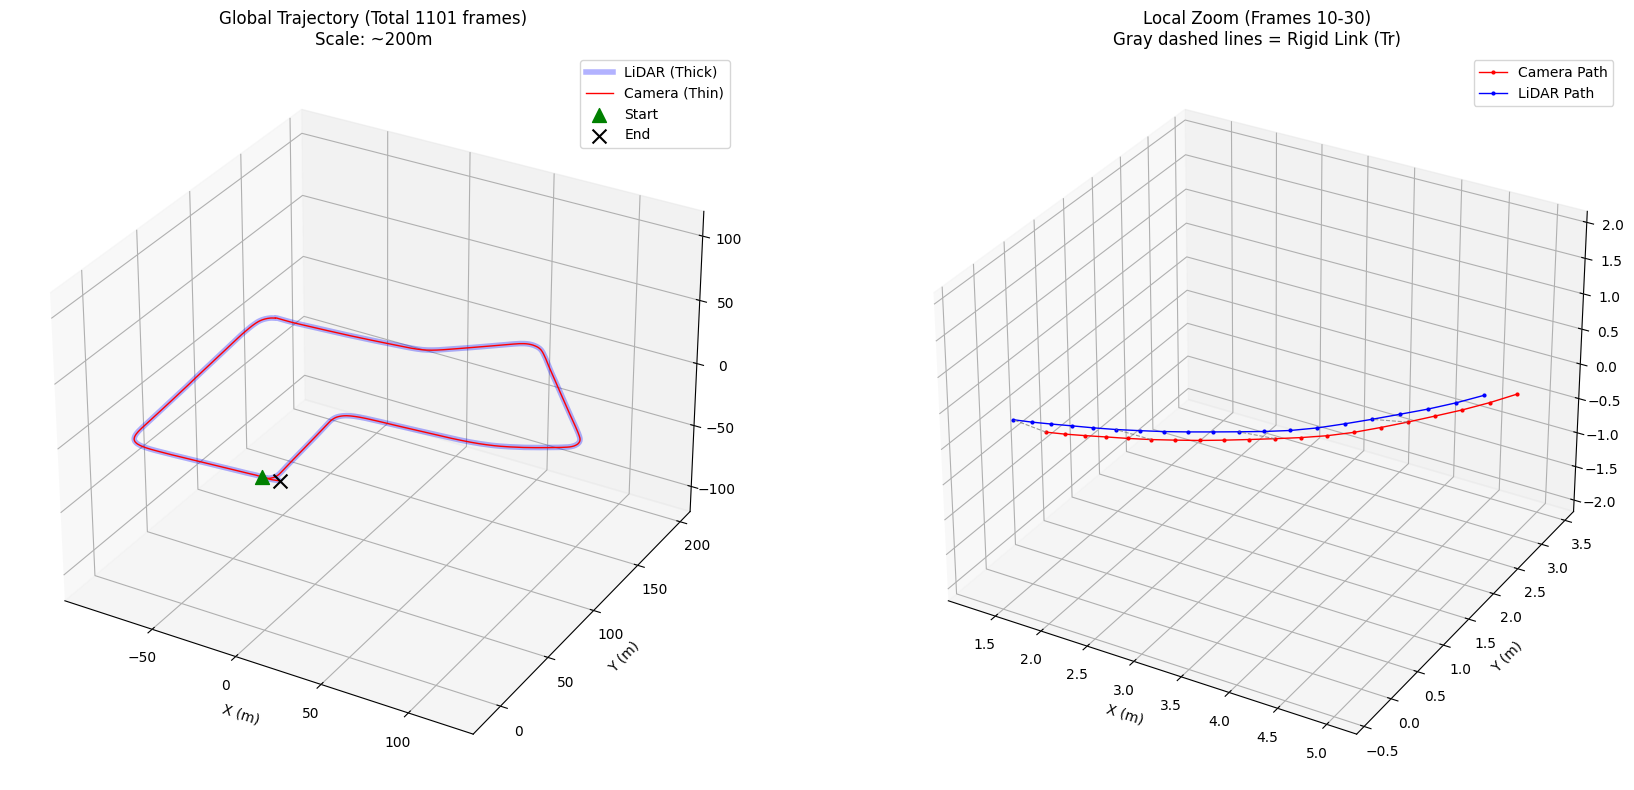

=== 物理一致性验证 ===
理论间距 (Tr模长): 0.3420 meters
实际轨迹平均间距: 0.3420 meters
误差: 0.000000 meters
>>> 验证通过 ✅: 刚体变换关系正确。


In [6]:
# ==========================================
# 6. 可视化对比 (改进版：全局 + 局部放大)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 补充数据生成部分
# ==========================================
handler = KittiPoseHandler(base_path)

# 容器，用于存放每一帧的坐标 (x, y, z)
cam_positions = []
lidar_positions = []

# 获取总帧数
num_frames = len(handler.raw_camera_poses)

print(f"正在计算 {num_frames} 帧的轨迹数据...")

# 遍历每一帧，计算坐标
for i in range(num_frames):
    # 1. 获取该帧在世界系下的 4x4 位姿矩阵
    pose_cam = handler.get_pose_in_world(frame_id=i, sensor_type='camera')
    pose_lidar = handler.get_pose_in_world(frame_id=i, sensor_type='lidar')
    
    # 2. 提取矩阵的平移向量 (第4列的前3行: x, y, z)
    # pose[:3, 3] 等同于取出 Translation Vector
    cam_positions.append(pose_cam[:3, 3])
    lidar_positions.append(pose_lidar[:3, 3])

# 3. 转换为 Numpy 数组，形状变为 (N, 3)，满足绘图需求
traj_world_cam = np.array(cam_positions)
traj_world_lidar = np.array(lidar_positions)

fig = plt.figure(figsize=(18, 8))

# --- 辅助函数：设置等比例坐标轴 (防止3D图被压扁) ---
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # 找出最大的范围
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# -------------------------------------------------------
# 子图 1：全局视角 (Global View)
# 策略：LiDAR 粗线半透明，Camera 细线深色，以显示重叠
# -------------------------------------------------------
ax1 = fig.add_subplot(121, projection='3d')

# 绘制雷达 (作为"基底"，画粗一点，半透明)
ax1.plot(traj_world_lidar[:, 0], traj_world_lidar[:, 1], traj_world_lidar[:, 2], 
        label='LiDAR (Thick)', color='blue', linewidth=4, alpha=0.3)

# 绘制相机 (作为"精细"轨迹，画细一点，深色)
ax1.plot(traj_world_cam[:, 0], traj_world_cam[:, 1], traj_world_cam[:, 2], 
        label='Camera (Thin)', color='red', linewidth=1, alpha=1.0)

# 标记起点和终点
ax1.scatter(traj_world_lidar[0,0], traj_world_lidar[0,1], traj_world_lidar[0,2], 
           c='green', marker='^', s=100, label='Start')
ax1.scatter(traj_world_lidar[-1,0], traj_world_lidar[-1,1], traj_world_lidar[-1,2], 
           c='black', marker='x', s=100, label='End')

ax1.set_title(f"Global Trajectory (Total {len(traj_world_cam)} frames)\nScale: ~200m")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.legend()
set_axes_equal(ax1) # 强制等比例

# -------------------------------------------------------
# 子图 2：局部放大视角 (Local Zoom)
# 策略：只画 50 帧，并画出两者之间的连接线（刚体约束）
# -------------------------------------------------------
ax2 = fig.add_subplot(122, projection='3d')

# 选取一段比较有代表性的区间 (例如转弯处或起步阶段)
# 这里取第 10 帧 到 第 30 帧
start_idx, end_idx = 10, 30 
sub_cam = traj_world_cam[start_idx:end_idx]
sub_lidar = traj_world_lidar[start_idx:end_idx]

# 绘制局部轨迹点
ax2.plot(sub_cam[:, 0], sub_cam[:, 1], sub_cam[:, 2], 
         c='red', label='Camera Path', linewidth=1, marker='.', markersize=4)
ax2.plot(sub_lidar[:, 0], sub_lidar[:, 1], sub_lidar[:, 2], 
         c='blue', label='LiDAR Path', linewidth=1, marker='.', markersize=4)

# *** 关键可视化：绘制连接线 (Rigid Link) ***
# 每隔 5 帧画一条连接相机的雷达的线，证明它们的相对位置是固定的
for i in range(0, len(sub_cam), 5):
    # 画线: 从 Camera[i] 到 LiDAR[i]
    ax2.plot([sub_cam[i, 0], sub_lidar[i, 0]],
             [sub_cam[i, 1], sub_lidar[i, 1]],
             [sub_cam[i, 2], sub_lidar[i, 2]],
             color='gray', linestyle='--', linewidth=0.8, alpha=0.8)

ax2.set_title(f"Local Zoom (Frames {start_idx}-{end_idx})\nGray dashed lines = Rigid Link (Tr)")
ax2.set_xlabel("X (m)")
ax2.set_ylabel("Y (m)")
ax2.legend()
set_axes_equal(ax2) # 强制等比例，这对观察局部偏移至关重要

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 物理一致性验证 (保持不变)
# ---------------------------------------------------
diff = traj_world_lidar - traj_world_cam
dist = np.linalg.norm(diff, axis=1)
mean_dist = np.mean(dist)
theoretical_dist = np.linalg.norm(handler.Tr[:3, 3])

print(f"=== 物理一致性验证 ===")
print(f"理论间距 (Tr模长): {theoretical_dist:.4f} meters")
print(f"实际轨迹平均间距: {mean_dist:.4f} meters")
print(f"误差: {abs(mean_dist - theoretical_dist):.6f} meters")

if np.isclose(mean_dist, theoretical_dist):
    print(">>> 验证通过 ✅: 刚体变换关系正确。")
else:
    print(">>> 验证失败 ❌: 距离不恒定。")